# A02: Frequency Domain Analysis (Quick Version)

**Duration**: ~30 minutes  
**Prerequisites**: A01 (Signals and Sampling), Basic Python, NumPy fundamentals

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/spectral.py` instead of defining them inline. For the full tutorial with step-by-step function implementations, see [A02_frequency_domain.ipynb](A02_frequency_domain.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the Fourier Transform as a tool for decomposing signals into frequency components
- Compute and interpret amplitude and phase spectra
- Apply frequency resolution concepts to determine spectral precision
- Analyze EEG-like signals in the frequency domain

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [The Fourier Transform Concept](#section-2-the-fourier-transform-concept)
3. [Computing the FFT](#section-3-computing-the-fft)
4. [Amplitude Spectrum](#section-4-amplitude-spectrum)
5. [Phase Spectrum](#section-5-phase-spectrum)
6. [Frequency Resolution](#section-6-frequency-resolution)
7. [Practical Example: EEG-like Signal](#section-7-practical-example-eeg-like-signal)
8. [Exercises](#section-8-hands-on-exercises)
9. [Summary](#summary)
10. [External Resources](#external-resources)
11. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS
from src.plotting import configure_plots
from src.signals import generate_time_vector, generate_sine_wave
from src.spectral import (
    compute_fft,
    compute_amplitude_spectrum,
    compute_phase_spectrum,
    compute_frequency_resolution,
)

# Apply plot configuration
configure_plots()

## Section 1: Introduction

In the previous notebook, we learned that signals are continuous phenomena sampled at discrete time points. We represented signals in the **time domain** — amplitude as a function of time.

But there's another way to represent signals: the **frequency domain**. Instead of asking "what is the amplitude at each moment?", we ask "what frequencies are present, and how strong is each one?"

This perspective is transformative for EEG analysis. Neural oscillations are fundamentally rhythmic, and the frequency domain reveals their structure directly. Alpha waves at 10 Hz, beta rhythms at 20 Hz, gamma bursts at 40 Hz — all become visible as peaks in the frequency spectrum.

The mathematical tool that converts between time and frequency domains is the **Fourier Transform**. In this notebook, we'll learn how to compute it efficiently using the Fast Fourier Transform (FFT) algorithm.

## Section 2: The Fourier Transform Concept

The Fourier Transform is based on a remarkable mathematical fact: **any signal can be decomposed into a sum of sine waves** at different frequencies, amplitudes, and phases.

Mathematically, the continuous Fourier Transform is:

$$X(f) = \int_{-\infty}^{\infty} x(t) \, e^{-i 2\pi f t} \, dt$$

For discrete signals (which is what we have after sampling), we use the **Discrete Fourier Transform (DFT)**:

$$X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-i 2\pi k n / N}$$

The output $X[k]$ is a complex number for each frequency bin $k$:
- The **magnitude** $|X[k]|$ tells us the amplitude at that frequency
- The **angle** $\angle X[k]$ tells us the phase (timing offset)

The **Fast Fourier Transform (FFT)** is an algorithm that computes the DFT in $O(N \log N)$ time instead of $O(N^2)$, making it practical for large signals.

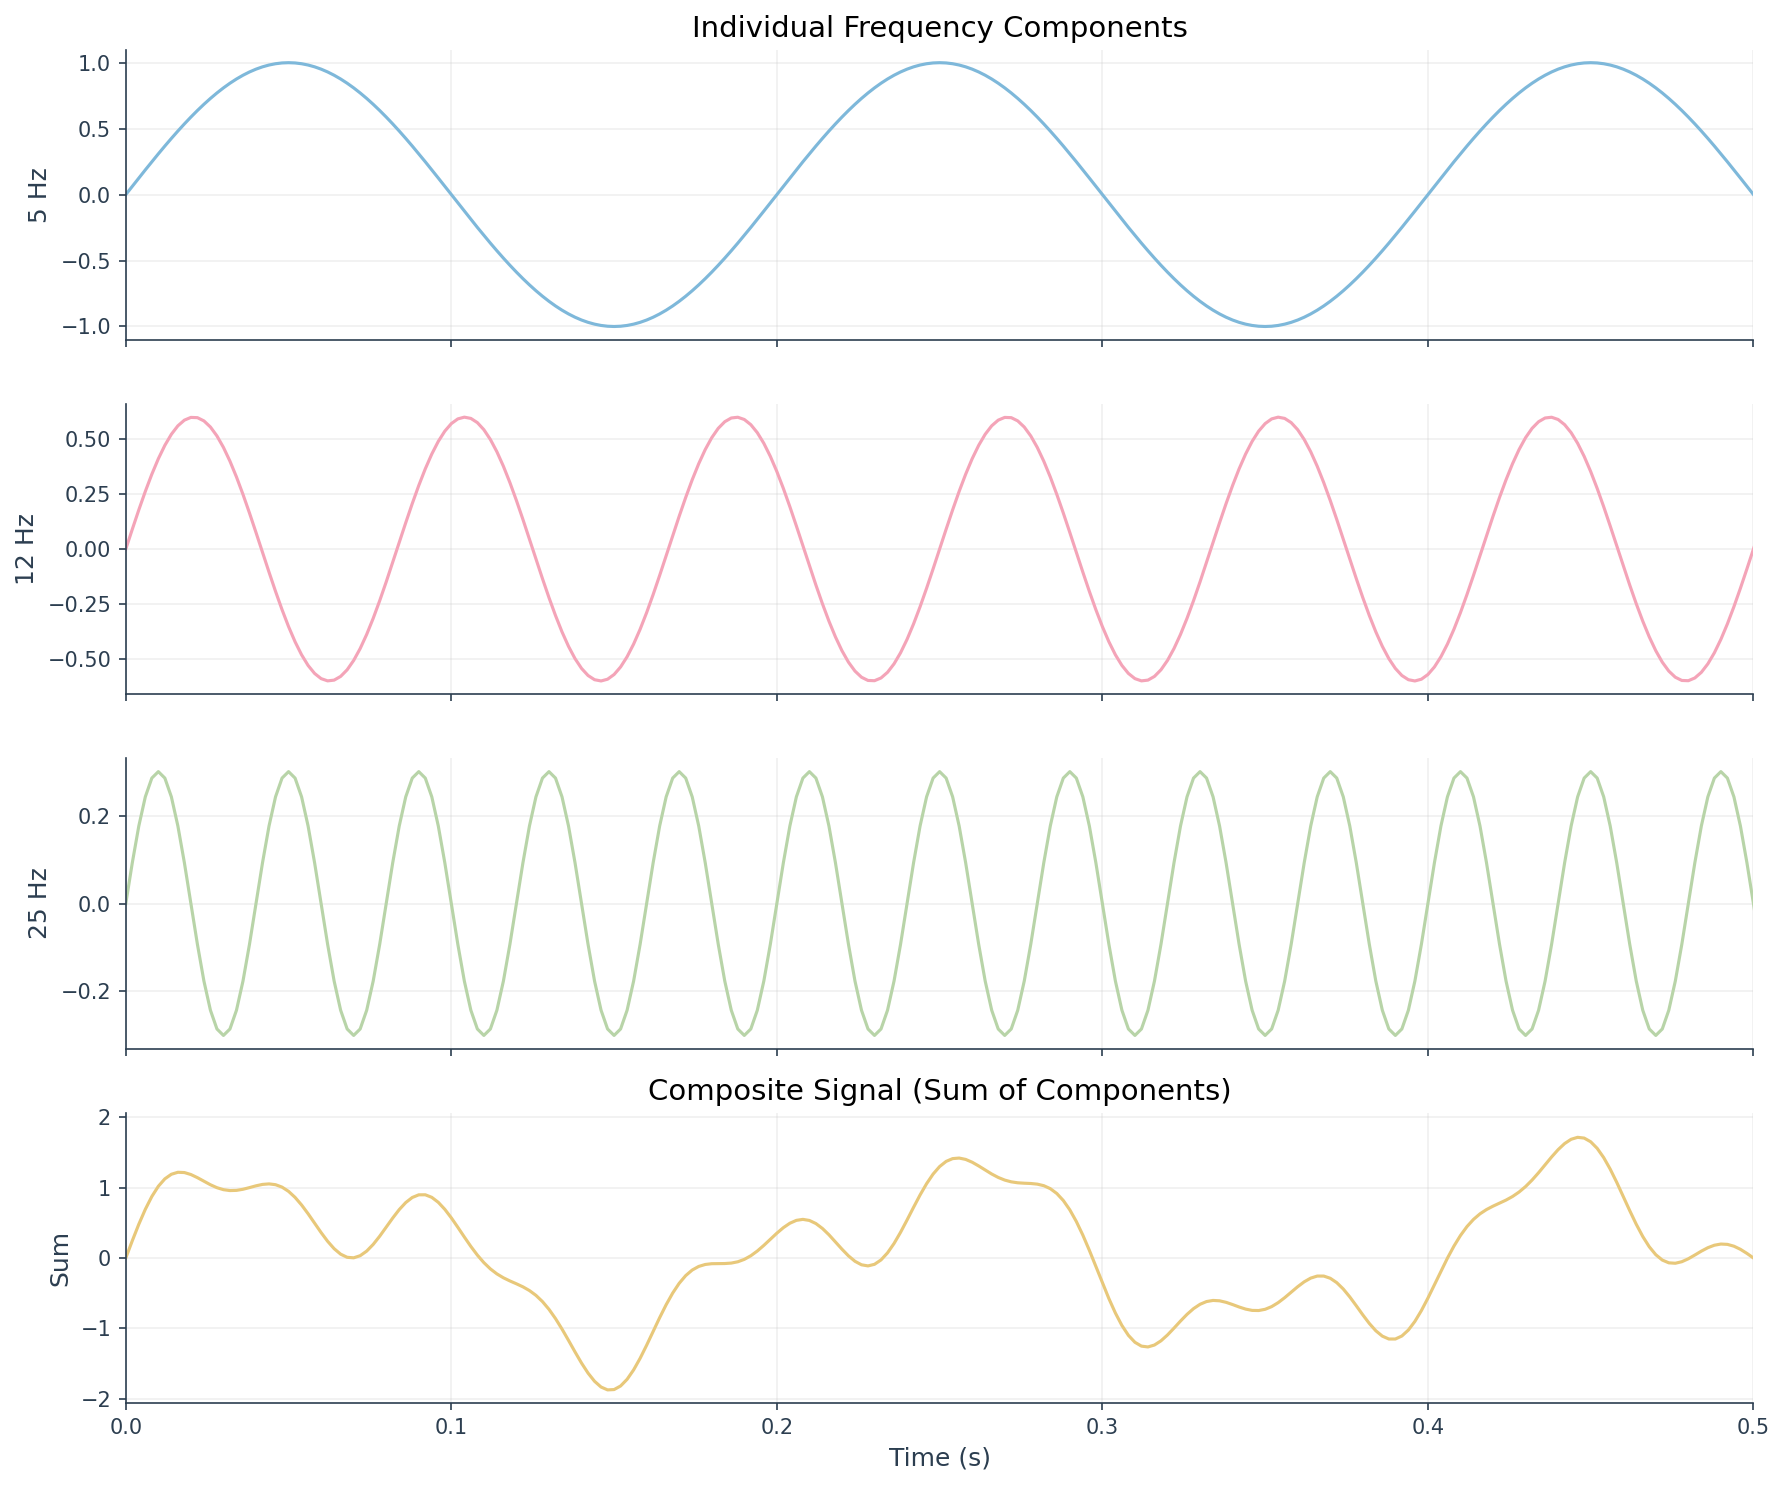

The composite signal contains: 5 Hz, 12 Hz, and 25 Hz
The Fourier Transform will recover these frequencies from the sum!


In [2]:
# Visualization 1: Decomposing a signal into frequency components

duration = 1.0
fs = 500
t = generate_time_vector(duration, fs)

# Create a composite signal from three frequencies
freq_1, amp_1 = 5, 1.0
freq_2, amp_2 = 12, 0.6
freq_3, amp_3 = 25, 0.3

component_1 = generate_sine_wave(t, freq_1, amp_1)
component_2 = generate_sine_wave(t, freq_2, amp_2)
component_3 = generate_sine_wave(t, freq_3, amp_3)
composite = component_1 + component_2 + component_3

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(t, component_1, color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_ylabel(f"{freq_1} Hz")
axes[0].set_title("Individual Frequency Components")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, component_2, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_ylabel(f"{freq_2} Hz")
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, component_3, color=COLORS["signal_3"], linewidth=1.5)
axes[2].set_ylabel(f"{freq_3} Hz")
axes[2].grid(True, alpha=0.3)

axes[3].plot(t, composite, color=COLORS["signal_4"], linewidth=1.5)
axes[3].set_ylabel("Sum")
axes[3].set_xlabel("Time (s)")
axes[3].set_title("Composite Signal (Sum of Components)")
axes[3].grid(True, alpha=0.3)

plt.xlim(0, 0.5)
plt.tight_layout()
plt.show()

print(f"The composite signal contains: {freq_1} Hz, {freq_2} Hz, and {freq_3} Hz")
print("The Fourier Transform will recover these frequencies from the sum!")

## Section 3: Computing the FFT

The `compute_fft` function from `src/spectral.py` computes the full FFT and returns both the frequency axis and the complex FFT values.

The frequency axis spans from $-f_s/2$ to $+f_s/2$ (the Nyquist range). For real-valued signals like EEG, the spectrum is symmetric, so we typically only look at positive frequencies.

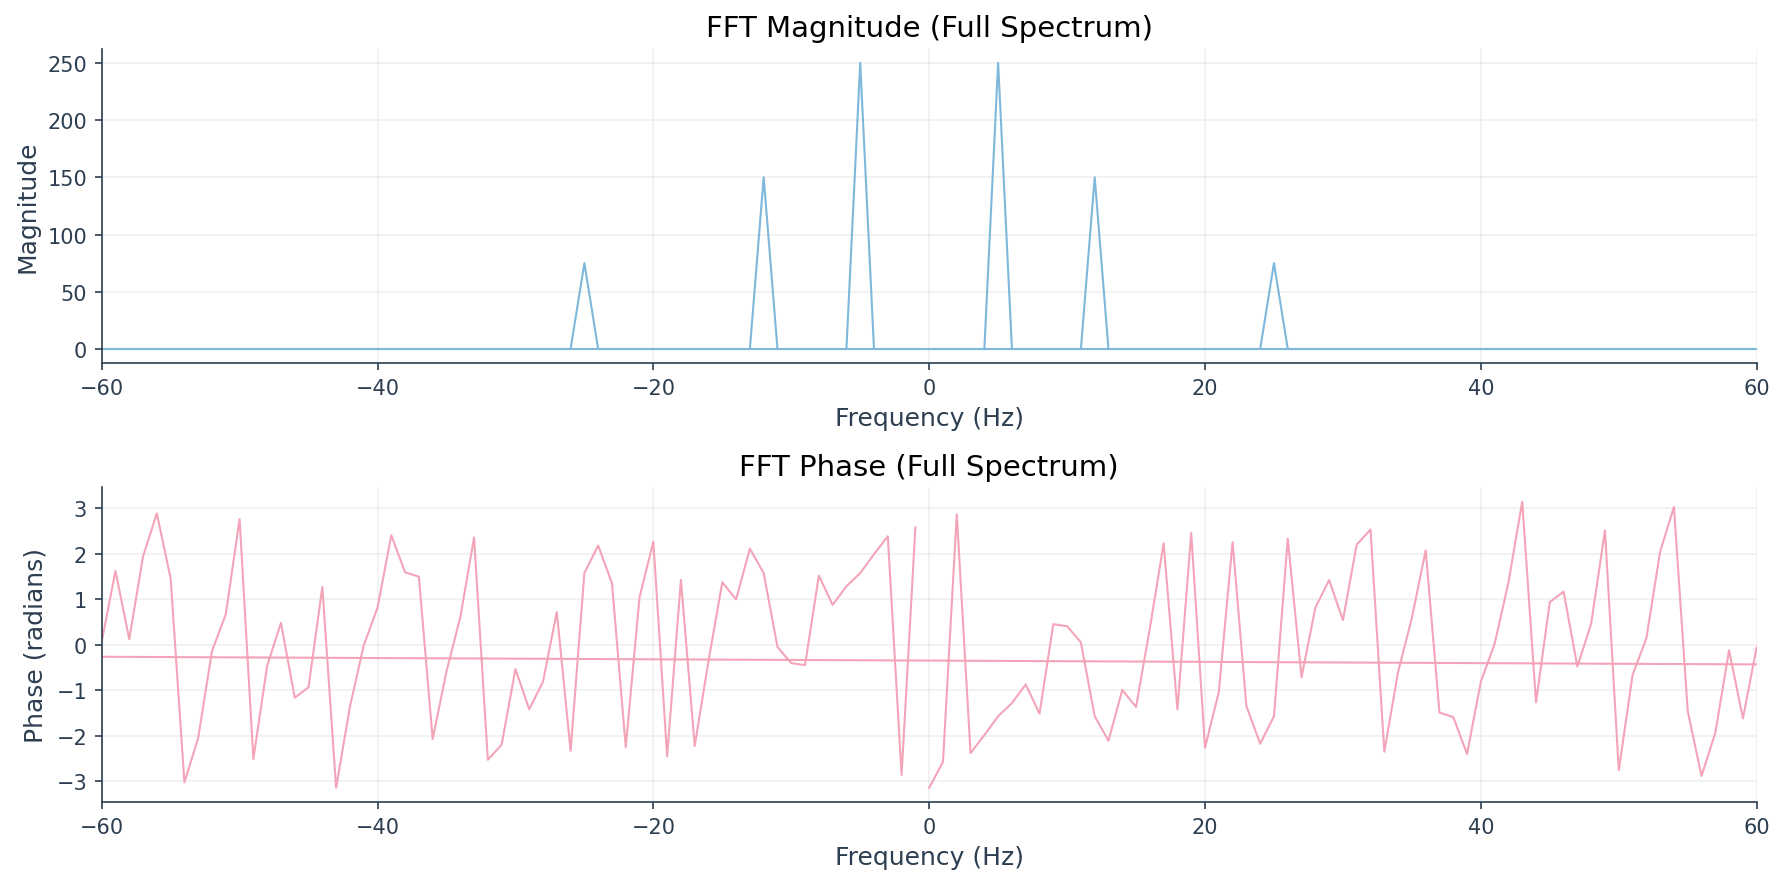

Notice: For real signals, the spectrum is symmetric around 0 Hz
We typically only show positive frequencies (one-sided spectrum)


In [3]:
# Visualization 2: Computing the FFT

# Compute FFT of our composite signal
frequencies, fft_values = compute_fft(composite, fs)

# The FFT output is complex - magnitude and phase
magnitude = np.abs(fft_values)
phase = np.angle(fft_values)

# Plot full spectrum (including negative frequencies)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(frequencies, magnitude, color=COLORS["signal_1"], linewidth=1)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Magnitude")
axes[0].set_title("FFT Magnitude (Full Spectrum)")
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-60, 60)

axes[1].plot(frequencies, phase, color=COLORS["signal_2"], linewidth=1)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Phase (radians)")
axes[1].set_title("FFT Phase (Full Spectrum)")
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-60, 60)

plt.tight_layout()
plt.show()

print("Notice: For real signals, the spectrum is symmetric around 0 Hz")
print("We typically only show positive frequencies (one-sided spectrum)")

## Section 4: Amplitude Spectrum

The **amplitude spectrum** shows the strength of each frequency component. It's computed from the magnitude of the FFT, properly scaled to recover the original amplitudes.

The `compute_amplitude_spectrum` function returns only positive frequencies (one-sided spectrum) with proper amplitude scaling.

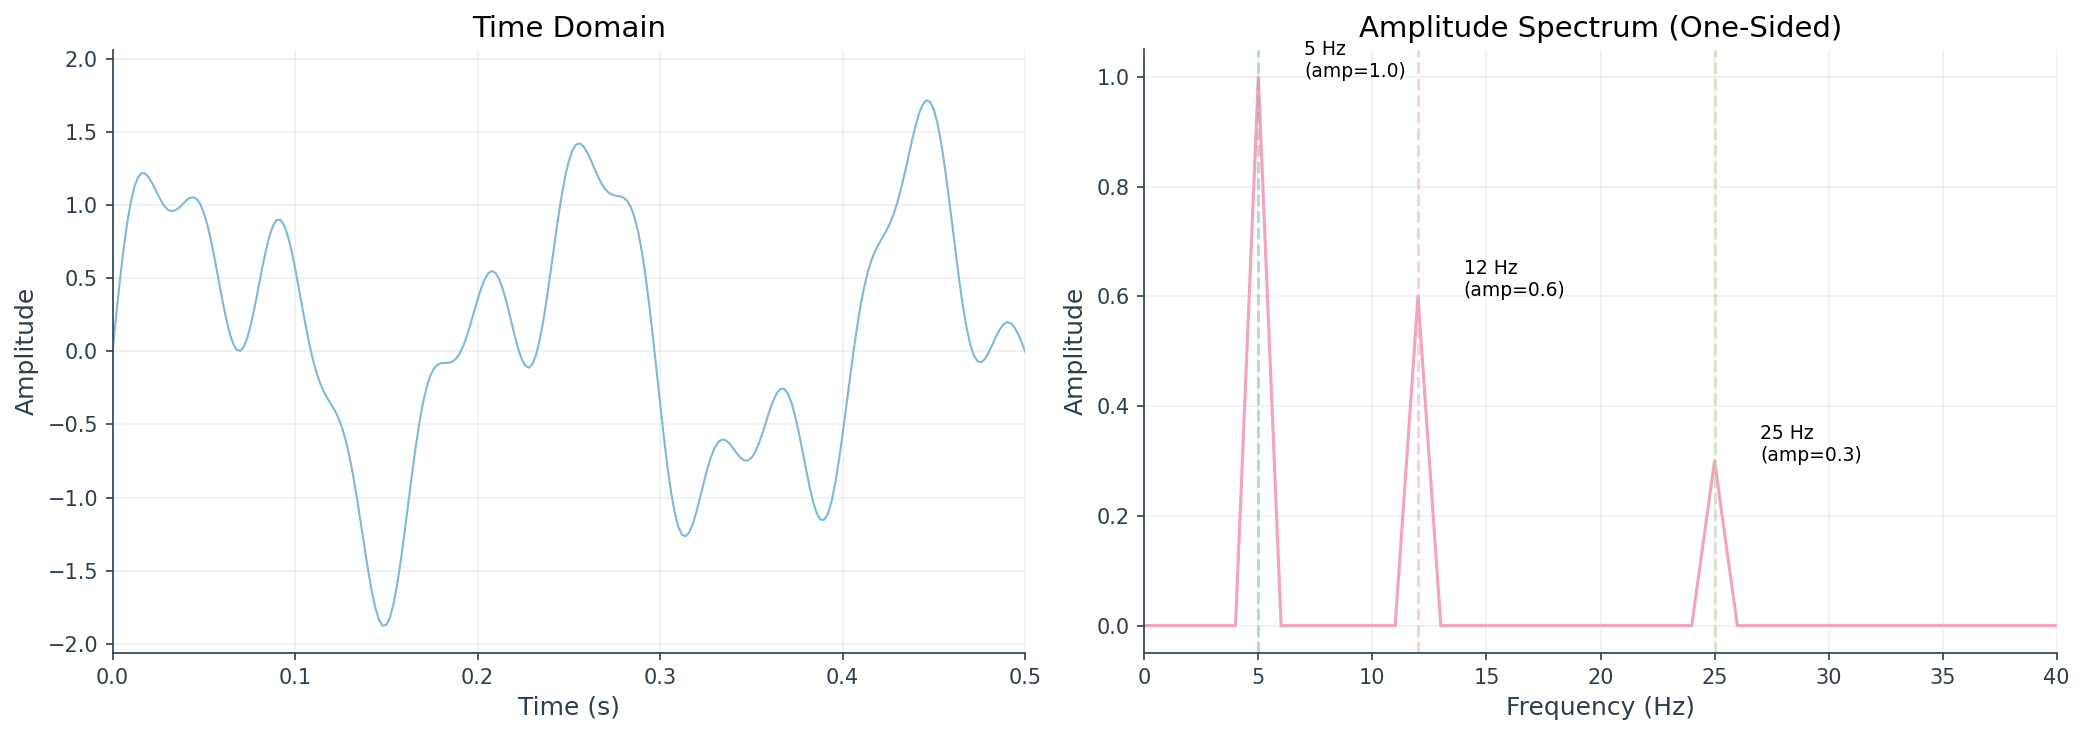

Original amplitudes: 1.0, 0.6, 0.3
The spectrum correctly shows peaks at 5, 12, and 25 Hz


In [4]:
# Visualization 3: Amplitude Spectrum

frequencies_pos, amplitude = compute_amplitude_spectrum(composite, fs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time domain
axes[0].plot(t, composite, color=COLORS["signal_1"], linewidth=1)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Time Domain")
axes[0].set_xlim(0, 0.5)
axes[0].grid(True, alpha=0.3)

# Frequency domain
axes[1].plot(frequencies_pos, amplitude, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Amplitude Spectrum (One-Sided)")
axes[1].set_xlim(0, 40)
axes[1].grid(True, alpha=0.3)

# Mark the peaks
for freq, amp, color in [(freq_1, amp_1, COLORS["signal_1"]), 
                          (freq_2, amp_2, COLORS["signal_2"]),
                          (freq_3, amp_3, COLORS["signal_3"])]:
    axes[1].axvline(freq, color=color, linestyle="--", alpha=0.5)
    axes[1].annotate(f"{freq} Hz\n(amp={amp})", xy=(freq, amp), 
                     xytext=(freq+2, amp), fontsize=9)

plt.tight_layout()
plt.show()

print(f"Original amplitudes: {amp_1}, {amp_2}, {amp_3}")
print(f"The spectrum correctly shows peaks at {freq_1}, {freq_2}, and {freq_3} Hz")

## Section 5: Phase Spectrum

The **phase spectrum** shows the timing offset of each frequency component. Two signals can have identical amplitude spectra but look completely different in the time domain if their phases differ.

Phase is measured in radians, ranging from $-\pi$ to $+\pi$.

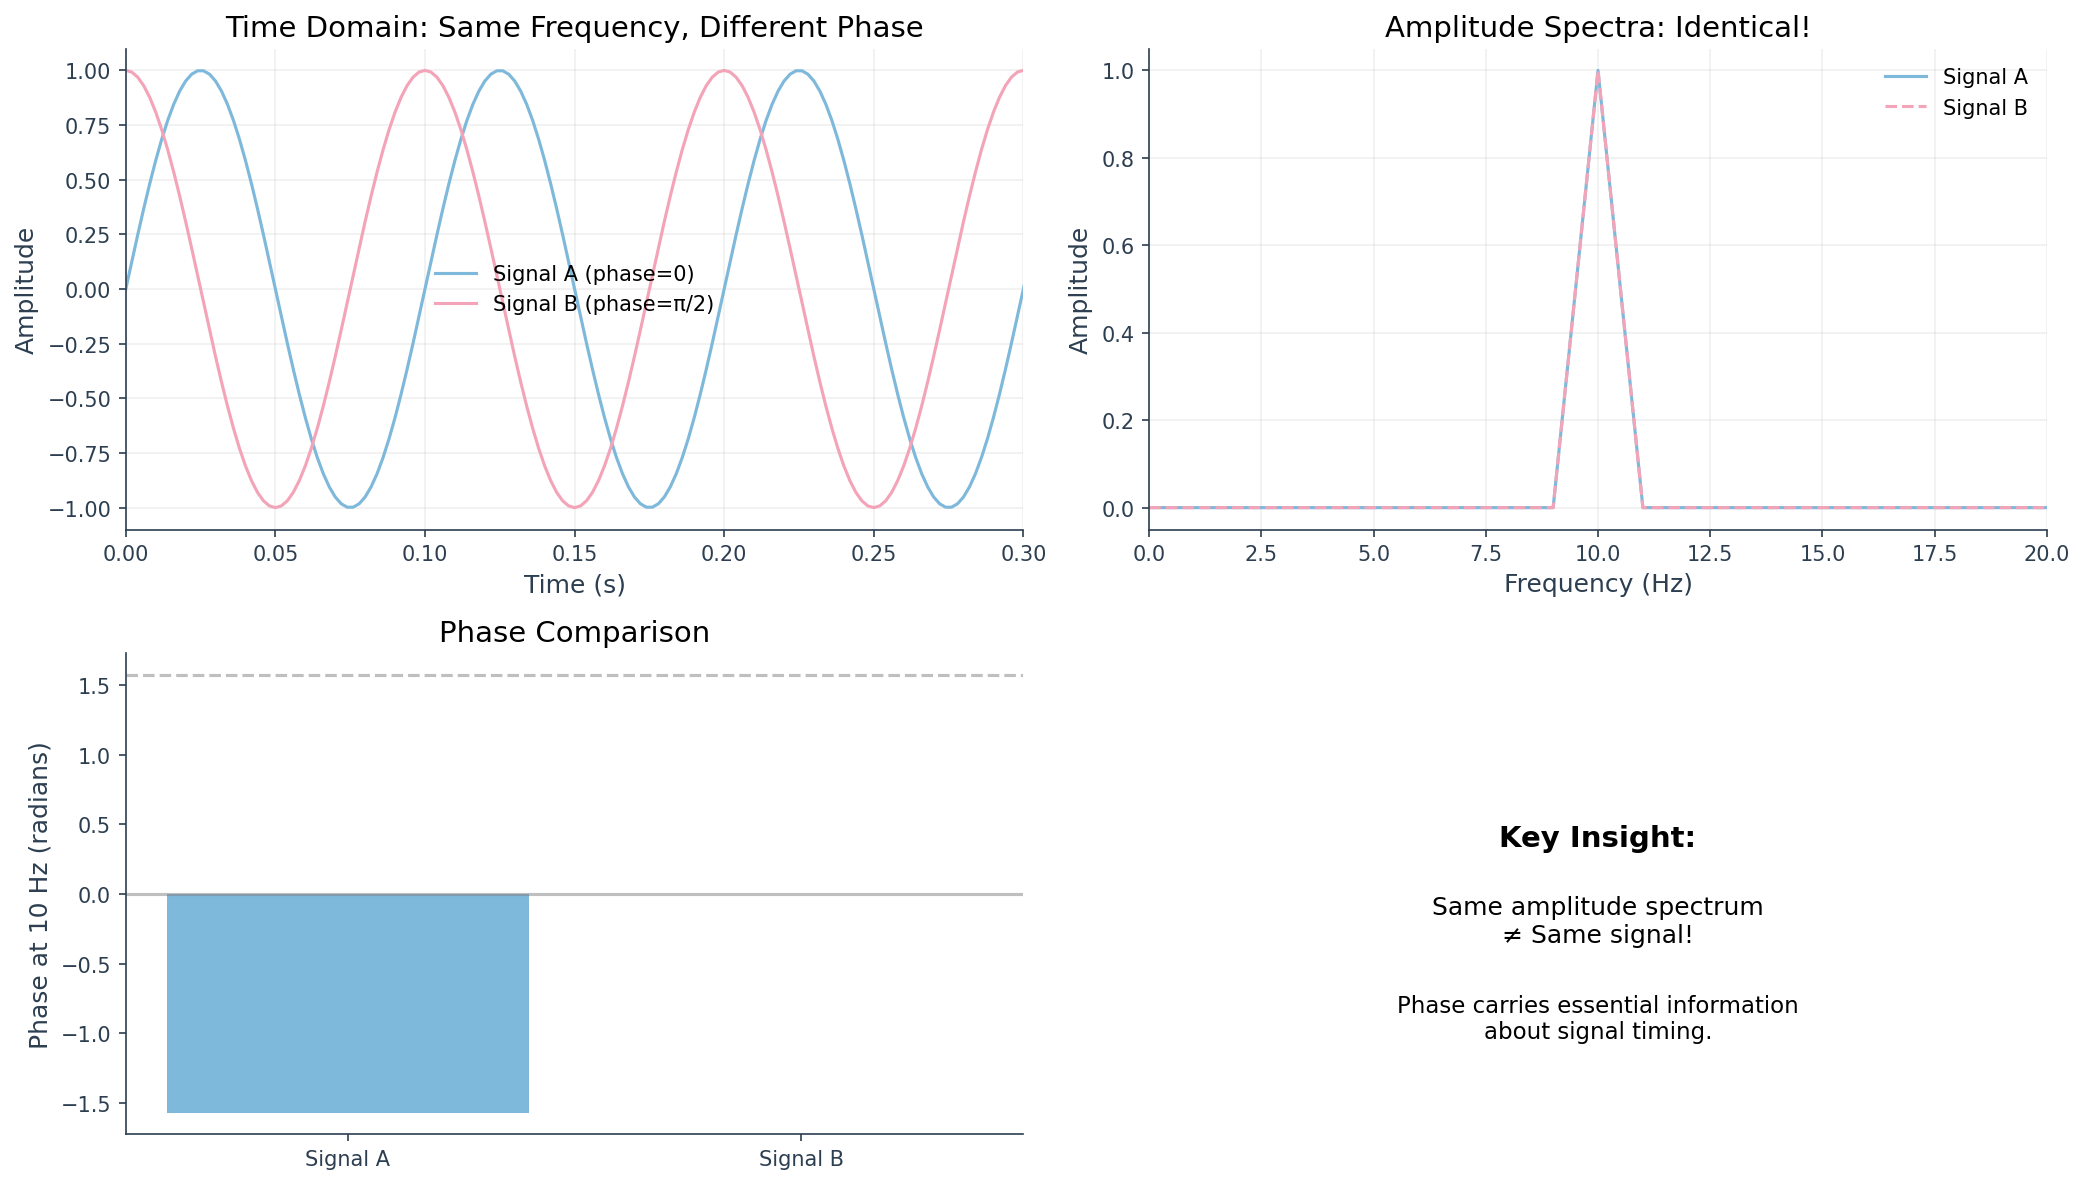

Phase at 10 Hz: Signal A = -1.571 rad, Signal B = 0.000 rad
Difference: 1.571 rad ≈ π/2 = 1.571 rad


In [5]:
# Visualization 4: Phase matters!

# Two signals with same amplitude but different phases
signal_A = generate_sine_wave(t, frequency=10, amplitude=1.0, phase=0)
signal_B = generate_sine_wave(t, frequency=10, amplitude=1.0, phase=np.pi/2)

# Compute spectra
freq_A, amp_A = compute_amplitude_spectrum(signal_A, fs)
freq_B, amp_B = compute_amplitude_spectrum(signal_B, fs)
_, phase_A = compute_phase_spectrum(signal_A, fs)
_, phase_B = compute_phase_spectrum(signal_B, fs)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time domain
axes[0, 0].plot(t, signal_A, color=COLORS["signal_1"], linewidth=1.5, label="Signal A (phase=0)")
axes[0, 0].plot(t, signal_B, color=COLORS["signal_2"], linewidth=1.5, label="Signal B (phase=π/2)")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Time Domain: Same Frequency, Different Phase")
axes[0, 0].set_xlim(0, 0.3)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Amplitude spectra (identical)
axes[0, 1].plot(freq_A, amp_A, color=COLORS["signal_1"], linewidth=1.5, label="Signal A")
axes[0, 1].plot(freq_B, amp_B, color=COLORS["signal_2"], linewidth=1.5, linestyle="--", label="Signal B")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].set_title("Amplitude Spectra: Identical!")
axes[0, 1].set_xlim(0, 20)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase at 10 Hz
idx_10 = np.argmin(np.abs(freq_A - 10))
axes[1, 0].bar(["Signal A", "Signal B"], [phase_A[idx_10], phase_B[idx_10]], 
               color=[COLORS["signal_1"], COLORS["signal_2"]])
axes[1, 0].set_ylabel("Phase at 10 Hz (radians)")
axes[1, 0].set_title("Phase Comparison")
axes[1, 0].axhline(0, color="gray", linestyle="-", alpha=0.5)
axes[1, 0].axhline(np.pi/2, color="gray", linestyle="--", alpha=0.5)

# Summary text
axes[1, 1].text(0.5, 0.6, "Key Insight:", fontsize=14, fontweight="bold",
                ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.4, "Same amplitude spectrum\n≠ Same signal!", fontsize=12,
                ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.2, "Phase carries essential information\nabout signal timing.", fontsize=11,
                ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

print(f"Phase at 10 Hz: Signal A = {phase_A[idx_10]:.3f} rad, Signal B = {phase_B[idx_10]:.3f} rad")
print(f"Difference: {phase_B[idx_10] - phase_A[idx_10]:.3f} rad ≈ π/2 = {np.pi/2:.3f} rad")

## Section 6: Frequency Resolution

**Frequency resolution** ($\Delta f$) determines how precisely we can distinguish nearby frequencies. It depends on the signal duration:

$$\Delta f = \frac{1}{T} = \frac{f_s}{N}$$

where $T$ is the signal duration, $f_s$ is the sampling rate, and $N$ is the number of samples.

**Key insight**: To resolve two frequencies $\Delta f$ Hz apart, you need at least $1/\Delta f$ seconds of data.

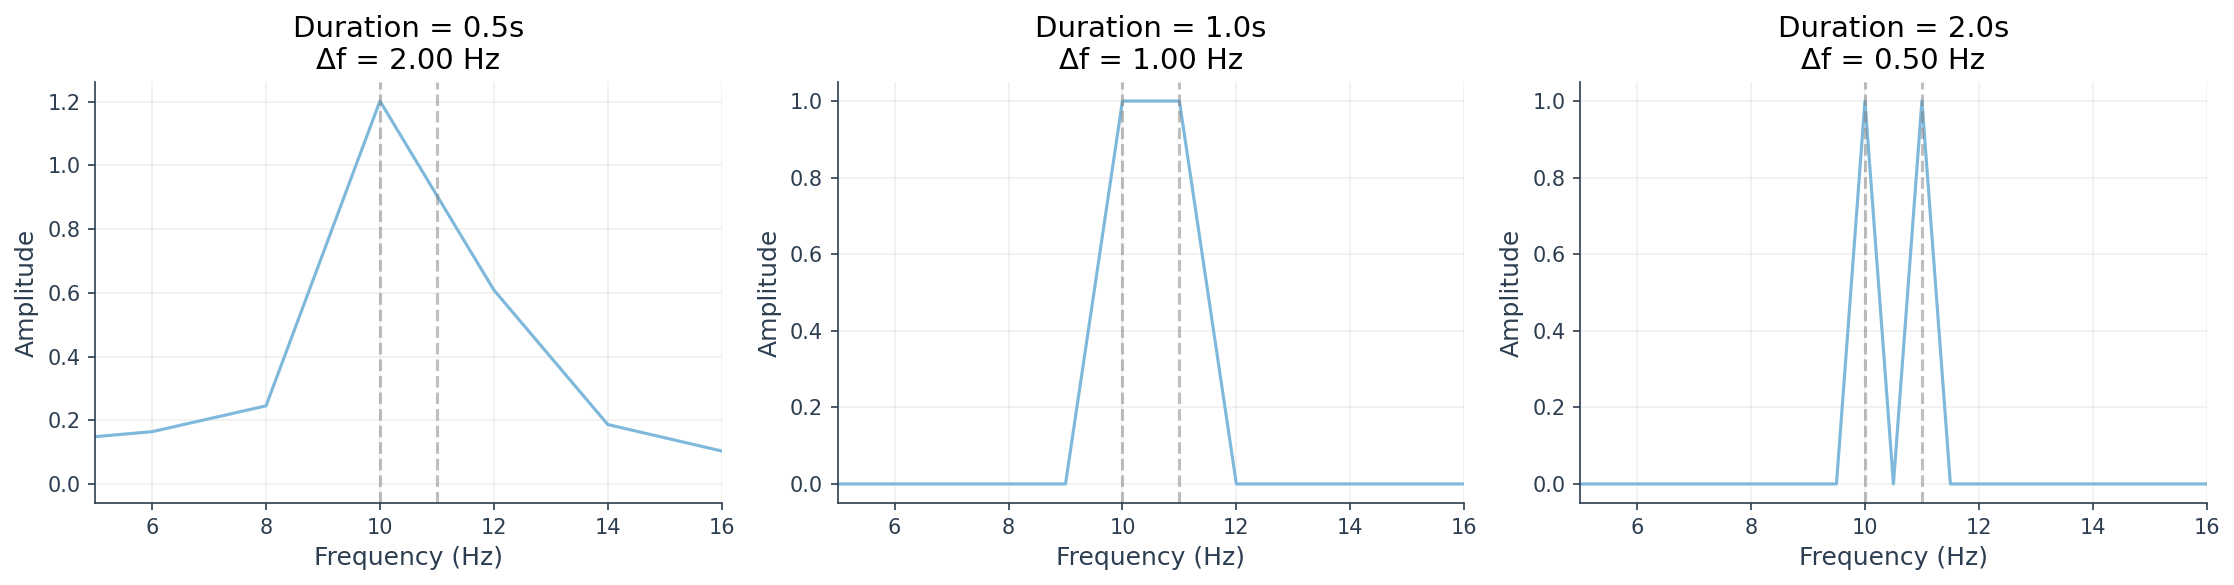

To resolve 10 Hz from 11 Hz (1 Hz apart):
  - 0.5s duration → Δf = 2 Hz → peaks MERGED
  - 1.0s duration → Δf = 1 Hz → peaks JUST VISIBLE
  - 2.0s duration → Δf = 0.5 Hz → peaks CLEARLY SEPARATED


In [6]:
# Visualization 5: Frequency resolution depends on signal duration

fs = 500
freq_1, freq_2 = 10, 11  # Two close frequencies (1 Hz apart)

durations = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, dur in zip(axes, durations):
    t = generate_time_vector(dur, fs)
    signal = generate_sine_wave(t, freq_1, 1.0) + generate_sine_wave(t, freq_2, 1.0)
    
    freqs, amps = compute_amplitude_spectrum(signal, fs)
    delta_f = compute_frequency_resolution(fs, len(t))
    
    ax.plot(freqs, amps, color=COLORS["signal_1"], linewidth=1.5)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"Duration = {dur}s\nΔf = {delta_f:.2f} Hz")
    ax.set_xlim(5, 16)
    ax.axvline(freq_1, color="gray", linestyle="--", alpha=0.5)
    ax.axvline(freq_2, color="gray", linestyle="--", alpha=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("To resolve 10 Hz from 11 Hz (1 Hz apart):")
print("  - 0.5s duration → Δf = 2 Hz → peaks MERGED")
print("  - 1.0s duration → Δf = 1 Hz → peaks JUST VISIBLE")
print("  - 2.0s duration → Δf = 0.5 Hz → peaks CLEARLY SEPARATED")

## Section 7: Practical Example — EEG-like Signal

Let's apply everything we've learned to analyze a realistic EEG-like signal containing multiple brain rhythms.

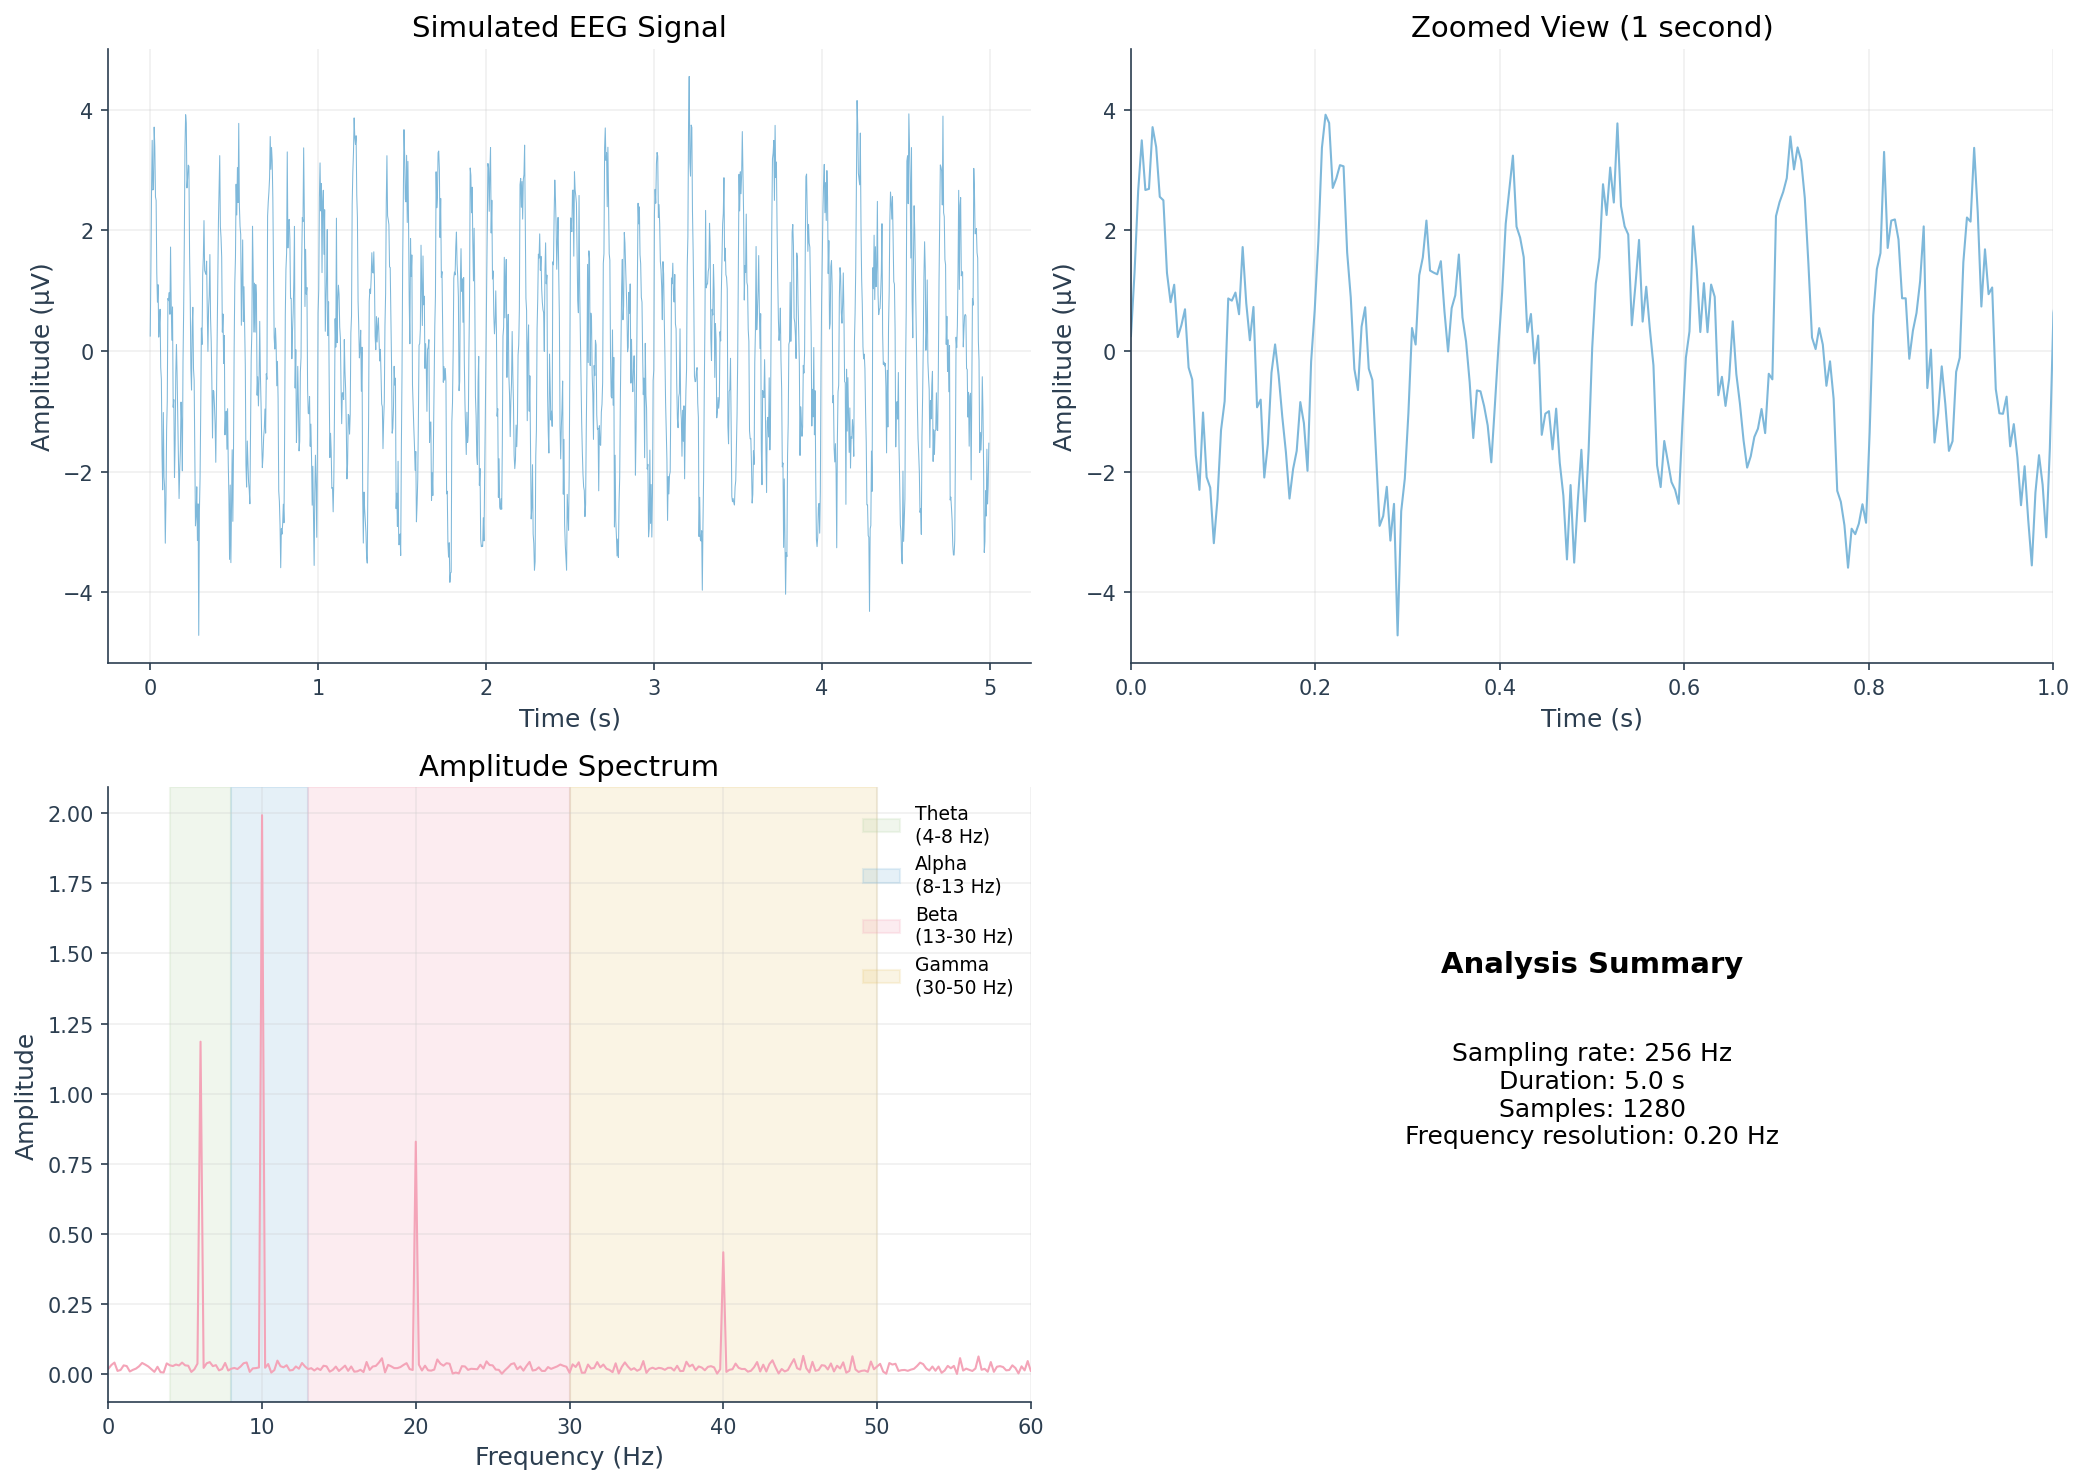

EEG-like signal contains:
  - Theta (6 Hz): memory, drowsiness
  - Alpha (10 Hz): relaxed wakefulness
  - Beta (20 Hz): active thinking
  - Gamma (40 Hz): cognitive processing


In [7]:
# Visualization 6: EEG-like signal analysis

duration = 5.0
fs = 256  # Common EEG sampling rate
t = generate_time_vector(duration, fs)

np.random.seed(42)

# Neural oscillations at different bands
theta = generate_sine_wave(t, frequency=6, amplitude=1.2)    # Theta (4-8 Hz)
alpha = generate_sine_wave(t, frequency=10, amplitude=2.0)   # Alpha (8-13 Hz)
beta = generate_sine_wave(t, frequency=20, amplitude=0.8)    # Beta (13-30 Hz)
gamma = generate_sine_wave(t, frequency=40, amplitude=0.4)   # Gamma (30-50 Hz)

# Add noise
noise = np.random.randn(len(t)) * 0.5

# Combine
eeg_signal = theta + alpha + beta + gamma + noise

# Compute spectrum
frequencies, amplitude_spectrum = compute_amplitude_spectrum(eeg_signal, fs)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time domain - full
axes[0, 0].plot(t, eeg_signal, color=COLORS["signal_1"], linewidth=0.5)
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Amplitude (μV)")
axes[0, 0].set_title("Simulated EEG Signal")
axes[0, 0].grid(True, alpha=0.3)

# Time domain - zoomed
axes[0, 1].plot(t, eeg_signal, color=COLORS["signal_1"], linewidth=1)
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Amplitude (μV)")
axes[0, 1].set_title("Zoomed View (1 second)")
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(True, alpha=0.3)

# Frequency domain with bands
axes[1, 0].plot(frequencies, amplitude_spectrum, color=COLORS["signal_2"], linewidth=1)
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].set_title("Amplitude Spectrum")
axes[1, 0].set_xlim(0, 60)
axes[1, 0].grid(True, alpha=0.3)

# Mark frequency bands
bands = {
    "Theta\n(4-8 Hz)": (4, 8, COLORS["signal_3"]),
    "Alpha\n(8-13 Hz)": (8, 13, COLORS["signal_1"]),
    "Beta\n(13-30 Hz)": (13, 30, COLORS["signal_2"]),
    "Gamma\n(30-50 Hz)": (30, 50, COLORS["signal_4"]),
}
for band_name, (f_low, f_high, color) in bands.items():
    axes[1, 0].axvspan(f_low, f_high, alpha=0.2, color=color, label=band_name)
axes[1, 0].legend(loc="upper right", fontsize=9)

# Frequency resolution info
delta_f = compute_frequency_resolution(fs, len(eeg_signal))
axes[1, 1].text(0.5, 0.7, "Analysis Summary", fontsize=14, fontweight="bold",
                ha="center", transform=axes[1, 1].transAxes)
axes[1, 1].text(0.5, 0.5, 
                f"Sampling rate: {fs} Hz\n"
                f"Duration: {duration} s\n"
                f"Samples: {len(eeg_signal)}\n"
                f"Frequency resolution: {delta_f:.2f} Hz",
                fontsize=12, ha="center", va="center", transform=axes[1, 1].transAxes)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

print("EEG-like signal contains:")
print("  - Theta (6 Hz): memory, drowsiness")
print("  - Alpha (10 Hz): relaxed wakefulness")
print("  - Beta (20 Hz): active thinking")
print("  - Gamma (40 Hz): cognitive processing")

## Section 8: Hands-On Exercises

### 🎯 Exercise 1: Mystery Signal Analysis 🟢

**Difficulty**: Beginner

A mystery signal is provided below. Use the FFT to identify its component frequencies.

**Your task**:
1. Compute the amplitude spectrum using `compute_amplitude_spectrum()`
2. Plot the spectrum and identify the peak frequencies
3. List all component frequencies in the signal

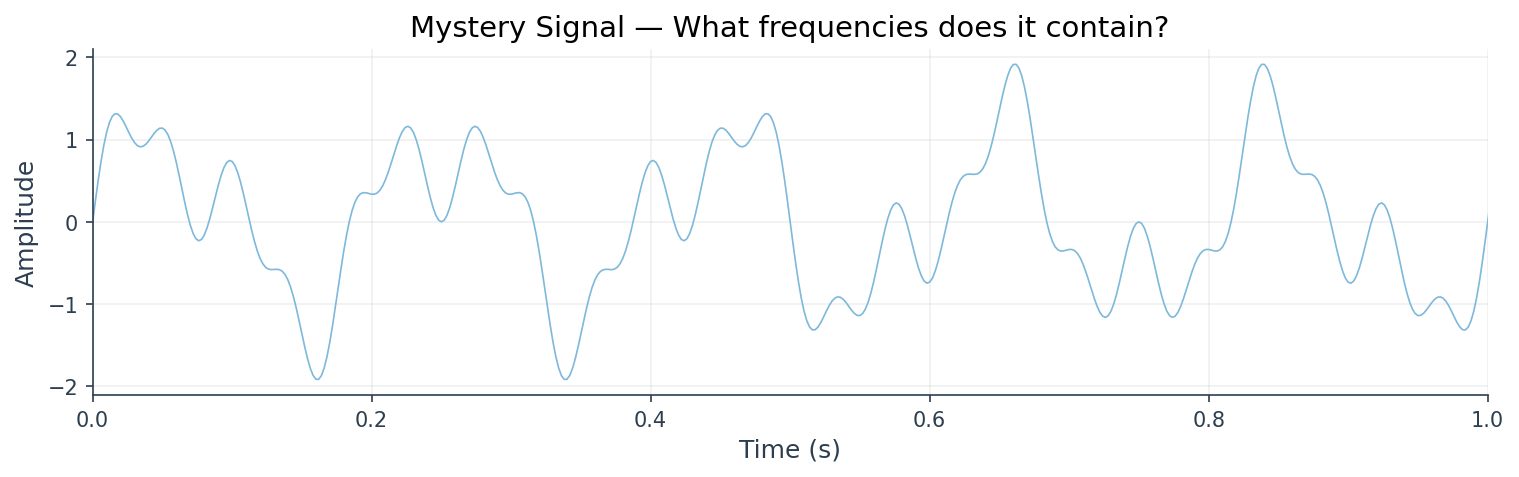

In [8]:
# Exercise 1: Mystery signal

np.random.seed(123)
fs_ex1 = 500
t_ex1 = generate_time_vector(duration=3.0, fs=fs_ex1)

# Mystery signal (don't peek at the frequencies!)
mystery_signal = (
    generate_sine_wave(t_ex1, frequency=5, amplitude=1.0) +
    generate_sine_wave(t_ex1, frequency=11, amplitude=0.6) +
    generate_sine_wave(t_ex1, frequency=23, amplitude=0.4)
)

# Plot the mystery signal
plt.figure(figsize=(12, 3))
plt.plot(t_ex1, mystery_signal, color=COLORS["signal_1"], linewidth=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Mystery Signal — What frequencies does it contain?")
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

# Your code here:
# freqs, amps = compute_amplitude_spectrum(mystery_signal, fs_ex1)
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
freqs, amps = compute_amplitude_spectrum(mystery_signal, fs_ex1)

plt.figure(figsize=(10, 4))
plt.plot(freqs, amps, color=COLORS["signal_1"], linewidth=1.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Mystery Signal — Amplitude Spectrum")
plt.xlim(0, 40)
plt.grid(True, alpha=0.3)
plt.show()

# Find peaks
peak_threshold = 0.2
peak_freqs = freqs[amps > peak_threshold]
print(f"Component frequencies: {peak_freqs}")
```

**Answer**: The mystery signal contains **5 Hz**, **11 Hz**, and **23 Hz** with amplitudes 1.0, 0.6, and 0.4 respectively.

</details>

### 🎯 Exercise 2: Frequency Resolution Challenge 🟡

**Difficulty**: Intermediate

Two frequencies (10 Hz and 11 Hz) are mixed together. Determine the minimum signal duration needed to resolve them as separate peaks.

**Your task**:
1. Calculate the theoretical minimum duration using $\Delta f = 1/T$
2. Verify by computing spectra at different durations
3. What duration would you recommend in practice?

In [9]:
# Exercise 2: Frequency resolution challenge

fs_ex2 = 500
freq_A, freq_B = 10, 11  # Only 1 Hz apart

# What is the minimum duration to resolve these frequencies?
# Hint: Δf = 1/T

# Your code here:
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Theoretical calculation
freq_separation = abs(freq_B - freq_A)  # 1 Hz
min_duration = 1 / freq_separation  # 1 second
print(f"Theoretical minimum duration: {min_duration} seconds")

# Verify experimentally
for dur in [0.5, 1.0, 2.0]:
    t = generate_time_vector(dur, fs_ex2)
    signal = generate_sine_wave(t, freq_A, 1.0) + generate_sine_wave(t, freq_B, 1.0)
    delta_f = compute_frequency_resolution(fs_ex2, len(t))
    print(f"Duration={dur}s → Δf={delta_f:.2f} Hz → {'RESOLVED' if delta_f <= freq_separation else 'NOT RESOLVED'}")
```

**Answer**: To resolve frequencies 1 Hz apart, you need at least 1 second of data (Δf ≤ 1 Hz). In practice, 2 seconds gives clearer separation.

</details>

## Summary

### Key Takeaways

1. **The Fourier Transform decomposes signals into frequency components** — any signal can be represented as a sum of sine waves

2. **The FFT is the efficient algorithm** to compute the DFT in $O(N \log N)$ time

3. **Amplitude spectrum** shows the strength of each frequency: $|X[k]|$

4. **Phase spectrum** shows the timing offset: $\angle X[k]$

5. **Frequency resolution depends on duration**: $\Delta f = 1/T$

6. **For real signals, the spectrum is symmetric** — we show only positive frequencies

### Functions Used

| Function | Description |
|----------|-------------|
| `compute_fft(signal, fs)` | Full FFT with frequency axis |
| `compute_amplitude_spectrum(signal, fs)` | One-sided amplitude spectrum |
| `compute_phase_spectrum(signal, fs)` | One-sided phase spectrum |
| `compute_frequency_resolution(fs, n_samples)` | Calculate Δf |

### Next Steps

In the next notebook (**A03: Power Spectrum and Frequency Bands**), we will:
- Learn about power spectral density (PSD)
- Explore Welch's method for robust spectral estimation
- Define and extract EEG frequency bands

---

## External Resources

### 🎥 Video Summary

- **[Frequency Domain Analysis - Video Overview](https://notebooklm.google.com/notebook/6ae43fc0-9141-4764-8774-aac72f1ec3c9?artifactId=2ea6754c-0c43-49b5-a1f0-155dd090861b)** — AI-generated video summary of this notebook's key concepts

### 📝 Practice & Review

- **[Quiz: Test Your Understanding](https://notebooklm.google.com/notebook/6ae43fc0-9141-4764-8774-aac72f1ec3c9?artifactId=7b1928a7-e87a-42d9-aabe-7a70923a95a2)** — Interactive quiz on Fourier Transform and spectral analysis
- **[Flashcards: Key Terms](https://notebooklm.google.com/notebook/6ae43fc0-9141-4764-8774-aac72f1ec3c9?artifactId=3d3ab500-7856-48ab-8d70-50a2d4bc4751)** — Review flashcards for spaced repetition learning

### 🎥 Video Tutorials

- **[Veritasium: The Remarkable Story Behind The Most Important Algorithm Of All Time](https://www.youtube.com/watch?v=nmgFG7PUHfo)** (20 min) — Fascinating history and intuition behind the FFT algorithm
- **[Steve Brunton: The Fast Fourier Transform (FFT)](https://www.youtube.com/watch?v=E8HeD-MUrjY)** (12 min) — Clear mathematical explanation with visual examples

### 📖 Further Reading

- **[Wikipedia: Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)** — Algorithm details and computational complexity
- **[BetterExplained: An Interactive Guide To The Fourier Transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)** — Intuitive interactive explanations

---

## Discussion Questions

For the live session, consider the following questions:

1. **You record 1 second of EEG data. Can you distinguish between 10 Hz and 10.5 Hz oscillations? What about with 3 seconds of data?**

2. **Two EEG channels show identical amplitude spectra but different phase spectra. What might this indicate about the relationship between these brain regions?**

3. **Why do you think most EEG connectivity metrics (coherence, PLV, etc.) operate in the frequency domain rather than the time domain?**

4. **A colleague shows you an amplitude spectrum with a very sharp, narrow peak. What does this tell you about the underlying signal?**

5. **In hyperscanning, we analyze two brains simultaneously. How might phase relationships between two participants' EEG signals at the same frequency be meaningful?**